In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr
import scipy.interpolate as interpolate


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=6)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.0.109:55770 Dashboard: http://10.148.0.109:8787/status,Cluster Workers: 28 Cores: 28 Memory: 479.92 GB


In [17]:
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

### Load eulerian field average

In [33]:
eulerian_field = xr.open_dataset(root_path+run+'diagnostics/Eulerian_field_ZC.nc').persist()

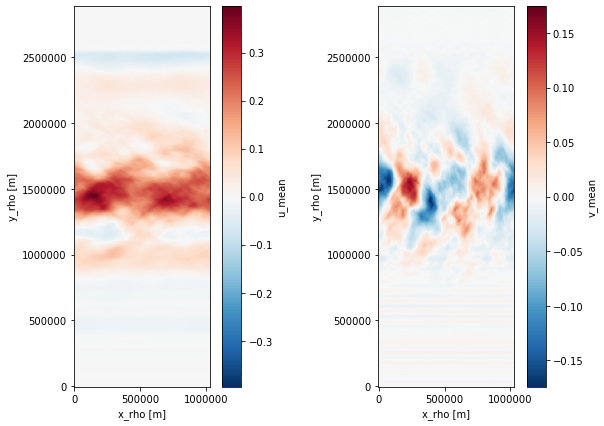

In [19]:
fig,axs = plt.subplots(1,2,figsize=(10,7))
for V,ax in zip(['u_mean','v_mean'],axs):
    eulerian_field[V].plot(ax=ax)
    ax.set_aspect('equal')

### Drifters trajectories

In [20]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=False)
dr

         time      xgrid      ygrid  zgrid     depth       temp         u  \
id                                                                          
1   1514.4167  25.897255  174.72748   50.0  0.870458  24.579730 -0.000864   
1   1508.3056  26.356433  168.51951   50.0  0.763907  24.579722  0.059964   
1   1508.2986  26.348080  168.48829   50.0  0.764288  24.579721  0.054308   
1   1508.2917  26.340585  168.45690   50.0  0.764393  24.579721  0.048543   
1   1508.2847  26.333961  168.42548   50.0  0.764202  24.579721  0.042720   

           v      dudt          dvdt      pres           x          y  
id                                                                     
1   0.089855  0.000009 -9.453702e-06  9.414380  103.589020  698.90992  
1   0.203875  0.000010 -4.799399e-06  8.369084  105.425732  674.07804  
1   0.207708  0.000010 -3.143696e-06  8.372827  105.392320  673.95316  
1   0.209148  0.000010 -1.401524e-06  8.373855  105.362340  673.82760  
1   0.209600  0.000010  3.03

In [21]:
#test interpolation  on  drifter trajectories : 
df = dr.df.loc[225].compute()

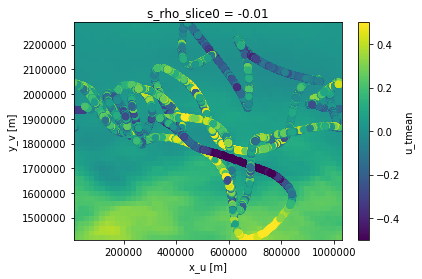

In [38]:
#
eulerian_field.u_tmean.sel(x_rho=slice(df.x.min()*1e3,df.x.max()*1e3),y_rho=slice(df.y.min()*1e3,df.y.max()*1e3)).plot(vmin=-0.5,vmax=0.5,zorder=-1)
plt.scatter(df.x*1e3,df.y*1e3,c=df.u,vmin=-0.5,vmax=0.5)

In [9]:
mean_zon = eulerian_field.mean('x_rho')

In [106]:
uE = mean_zon.u_tmean.sel(y_rho=slice((df.y.min()-100)*1e3,(df.y.max()+100)*1e3))

number of points in y direction in eulerian field :  54
number of points in y direction along drifter trajectory :  71735


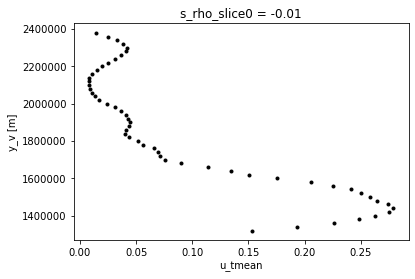

In [108]:
uE.plot.line('k.',y='y_rho')
print('number of points in y direction in eulerian field : ',uE.y_rho.size)
print('number of points in y direction along drifter trajectory : ',df.y.unique().size)

In [130]:
f = interpolate.interp1d(uE.y_rho,uE,kind='cubic')

In [107]:
print(uE.y_rho.max(),df.y.max()*1e3)

<xarray.DataArray 'y_rho' ()>
array(2380000., dtype=float32)
Coordinates:
    s_rho_slice0  float32 -0.01 2289850.52


In [131]:
uinterp = f(df.y*1e3)

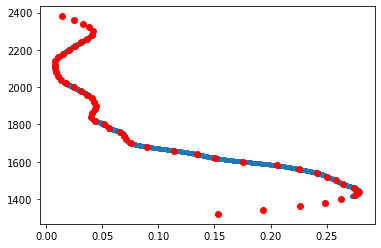

In [132]:
plt.plot(uinterp,df.y,'.')
plt.plot(uE,uE.y_rho*1e-3,'ro')

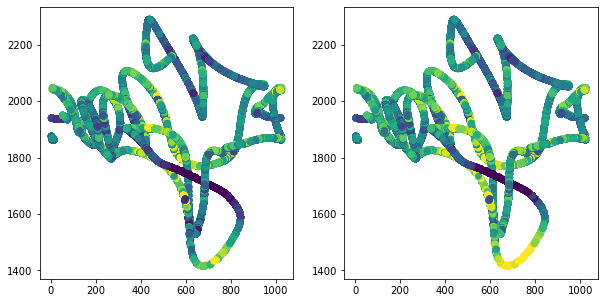

In [124]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df.x,df.y,c=(df.u-uinterp),vmin=-0.5,vmax=0.5)
ax[1].scatter(df.x,df.y,c=df.u,vmin=-0.5,vmax=0.5)

### Over all drifters:

In [21]:
def interpolate_avg(ds,field,columns,dimension='1d'):
    if dimension=='1d':
        avg = field.mean('x_rho').interp(y_rho=ds.y*1e3).get(columns)
    if dimension=='2d':
        x = xr.Datarray(ds.x.values,dims='pos')
        y = xr.Datarray(ds.y.values,dims='pos')
        avg = field.interp(x_rho=x*1e3,y_rho=y*1e3).get(columns)
        #out = avg.get(columns)#.to_dataframe().drop(columns=['f','s_rho_slice0','f_rho'])
    for var in columns:
        ds[var] = ds[var]-avg[var]
    return ds

In [24]:
E_field = eulerian_field.rename({'u_mean':'u','v_mean':'v'})

In [16]:
print(df.u-E_field.mean('x_rho').interp(y_rho=df.y*1e3).u)
print(df.u)

id
225   -0.011964
225   -0.017582
225    0.273156
225    0.177909
225    0.174922
         ...   
225   -0.065201
225    0.561622
225    0.114852
225    0.059482
225    0.092692
Name: u, Length: 72004, dtype: float64
id
225    0.028135
225    0.022532
225    0.286140
225    0.218889
225    0.188402
         ...   
225   -0.056717
225    0.839395
225    0.125162
225    0.068251
225    0.120743
Name: u, Length: 72004, dtype: float64


In [24]:
out = interpolate_E(df,E_field,['u','v'])#.rename(columns={'u_tmean':'u','v_tmean':'v'})

#### Apply interpolation and remove mean eulerian field from drifters trajectories (pre-processing)

In [26]:
DF = dr.df.groupby(dr.df.index).apply(interpolate_avg,E_field,['u','v']).persist()
DF

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


,time,xgrid,ygrid,zgrid,depth,temp,u,v,dudt,dvdt,pres,x,y
npartitions=753,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


In [27]:
def wrap_correlate(DS,columns,T,dt,L,binsize,detrend=True):
#df_chunked = dr.df.groupby(['id']).apply(chunk_processing, 10., .5)
    df_chunked = DS.groupby(DS.index).apply(cdr.time_window_processing,
                                            cdr.correlate, columns, T, int(T/dt/2),L, detrend=detrend,dt=dt
                                           ).persist()
                                         #   meta=('x', 'f8'))
    # the dataframe partitions has a multi-index: id and window central time (unknow name for now)
    # we first transform the index corresponding to time into a regular column.
    df_chunked = (
                  df_chunked.map_partitions(
                      lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                           )
                  )
    # bin along y and sum
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
    return df_chunked

In [28]:
# inputs: time window and step
T = 20 # days
dt = 10./60./24. # days, hack required because dt fluctuates by a bit !!
binsize = 50
L = 1024

In [29]:
df_chunked = wrap_correlate(DF,['u','u'],T,dt,L,binsize,detrend=False)
df_chunked

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


Dask DataFrame Structure:
                  time        x        y       id      0.0 0.006944444444444444 0.013888888888888888 0.020833333333333332 0.027777777777777776 0.034722222222222224 0.041666666666666664 0.048611111111111105 0.05555555555555555   0.0625 0.06944444444444445 0.07638888888888888 0.08333333333333333 0.09027777777777778 0.09722222222222221 0.10416666666666666 0.1111111111111111 0.11805555555555555    0.125 0.13194444444444445 0.1388888888888889 0.14583333333333331 0.15277777777777776 0.1597222222222222 0.16666666666666666 0.1736111111111111 0.18055555555555555   0.1875 0.19444444444444442 0.20138888888888887 0.20833333333333331 0.21527777777777776 0.2222222222222222 0.22916666666666666 0.2361111111111111 0.24305555555555555     0.25 0.2569444444444444 0.2638888888888889 0.2708333333333333 0.2777777777777778 0.2847222222222222 0.29166666666666663 0.2986111111111111 0.3055555555555555   0.3125 0.3194444444444444 0.3263888888888889 0.3333333333333333 0.34027777777777773 0.3472222222222222 0.35416666666666663 0.3611111111111111 0.3680555555555555    0.375 0.3819444444444444 0.38888888888888884 0.3958333333333333 0.40277777777777773 0.4097222222222222 0.41666666666666663 0.4236111111111111 0.4305555555555555   0.4375 0.4444444444444444 0.45138888888888884 0.4583333333333333 0.46527777777777773 0.4722222222222222 0.47916666666666663 0.4861111111111111 0.4930555555555555      0.5 0.5069444444444444 0.5138888888888888 0.5208333333333333 0.5277777777777778 0.5347222222222222 0.5416666666666666 0.548611111111111 0.5555555555555556   0.5625 0.5694444444444444 0.5763888888888888 0.5833333333333333 0.5902777777777778 0.5972222222222222 0.6041666666666666 0.611111111111111 0.6180555555555555    0.625 0.6319444444444444 0.6388888888888888 0.6458333333333333 0.6527777777777778 0.6597222222222222 0.6666666666666666 0.673611111111111 0.6805555555555555   0.6875 0.6944444444444444 0.7013888888888888 0.7083333333333333 0.7152777777777778 0.7222222222222222 0.7291666666666666 0.736111111111111 0.7430555555555555     0.75 0.7569444444444444 0.7638888888888888 0.7708333333333333 0.7777777777777777 0.7847222222222222 0.7916666666666666 0.798611111111111 0.8055555555555555   0.8125 0.8194444444444444 0.8263888888888888 0.8333333333333333 0.8402777777777777 0.8472222222222222 0.8541666666666666 0.861111111111111 0.8680555555555555    0.875 0.8819444444444444 0.8888888888888888 0.8958333333333333 0.9027777777777777 0.9097222222222222 0.9166666666666666 0.923611111111111 0.9305555555555555   0.9375 0.9444444444444444 0.9513888888888888 0.9583333333333333 0.9652777777777777 0.9722222222222222 0.9791666666666666 0.986111111111111 0.9930555555555555      1.0 1.0069444444444444 1.0138888888888888 1.0208333333333333 1.0277777777777777 1.034722222222222 1.0416666666666665 1.0486111111111112 1.0555555555555556   1.0625 1.0694444444444444 1.0763888888888888 1.0833333333333333 1.0902777777777777 1.097222222222222 1.1041666666666665 1.1111111111111112 1.1180555555555556    1.125 1.1319444444444444 1.1388888888888888 1.1458333333333333 1.1527777777777777 1.159722222222222 1.1666666666666665 1.173611111111111 1.1805555555555556   1.1875 1.1944444444444444 1.2013888888888888 1.2083333333333333 1.2152777777777777 1.222222222222222 1.2291666666666665 1.236111111111111 1.2430555555555556     1.25 1.2569444444444444 1.2638888888888888 1.2708333333333333 1.2777777777777777 1.284722222222222 1.2916666666666665 1.298611111111111 1.3055555555555556   1.3125 1.3194444444444444 1.3263888888888888 1.3333333333333333 1.3402777777777777 1.347222222222222 1.3541666666666665 1.361111111111111 1.3680555555555556    1.375 1.3819444444444444 1.3888888888888888 1.3958333333333333 1.4027777777777777 1.409722222222222 1.4166666666666665 1.423611111111111 1.4305555555555556   1.4375 1.4444444444444444 1.4513888888888888 1.4583333333333333 1.4652777777777777 1.472222222222222 1.4791666666666665 1.486111111111111 1.4930555555555556      1.5 1.5069444444444444 1.5138888888

In [30]:
uu = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(uu.set_index(uu.index.map(lambda v: v.mid))
              .drop(columns=['id','time','x','y'])
              .reset_index(), id_vars=['y_cut'], var_name='lag')
              .rename(columns={'y_cut': 'y_bins', 'value': 'uu'})).to_xarray().set_index(index=['y_bins','lag']).unstack()

In [31]:
df_chunked = wrap_correlate(DF,['v','v'],T,dt,L,binsize,detrend=False)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


In [34]:
vv = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds['vv'] = (pd.melt(vv.set_index(vv.index.map(lambda v: v.mid))
                    .drop(columns=['id','time','x','y'])
                    .reset_index(), id_vars=['y_cut'], var_name='lag')
                    .rename(columns={'y_cut': 'y_bins', 'value': 'vv'})).to_xarray().set_index(index=['y_bins','lag']).unstack().vv

In [38]:
df_chunked = wrap_correlate(DF,['u','v'],T,dt,L,binsize,detrend=False)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


In [39]:
uv = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds['uv'] = (pd.melt(uv.set_index(uv.index.map(lambda v: v.mid))
              .drop(columns=['id','time','x','y'])
              .reset_index(), id_vars=['y_cut'], var_name='lag')
              .rename(columns={'y_cut': 'y_bins', 'value': 'uv'})).to_xarray().set_index(index=['y_bins','lag']).unstack().uv

In [40]:
df_chunked = wrap_correlate(DF,['v','u'],T,dt,L,binsize,detrend=False)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


In [41]:
vu = df_chunked.groupby(['y_cut']).mean().compute()
#Converting pandas dataframe in xarray dataset:
ds['vu'] = (pd.melt(vu.set_index(vu.index.map(lambda v: v.mid))
              .drop(columns=['id','time','x','y'])
              .reset_index(), id_vars=['y_cut'], var_name='lag')
              .rename(columns={'y_cut': 'y_bins', 'value': 'vu'})).to_xarray().set_index(index=['y_bins','lag']).unstack().vu

In [42]:
ds

<xarray.Dataset>
Dimensions:  (lag: 1440, y_bins: 55)
Coordinates:
  * y_bins   (y_bins) float64 25.0 75.0 125.0 ... 2.625e+03 2.675e+03 2.725e+03
  * lag      (lag) float64 0.0 0.006944 0.01389 0.02083 ... 9.979 9.986 9.993
Data variables:
    uu       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    vv       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    uv       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    vu       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan

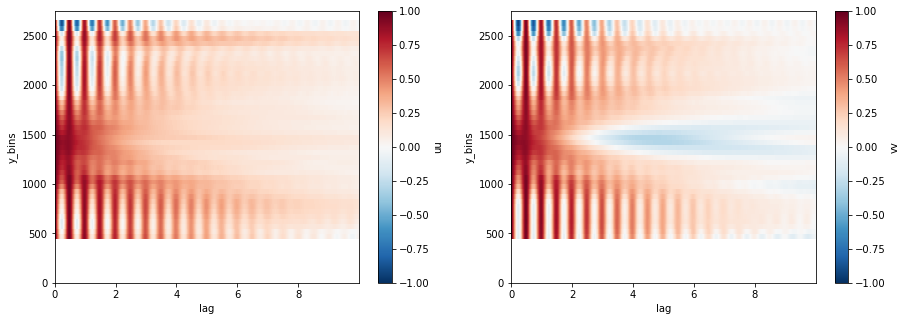

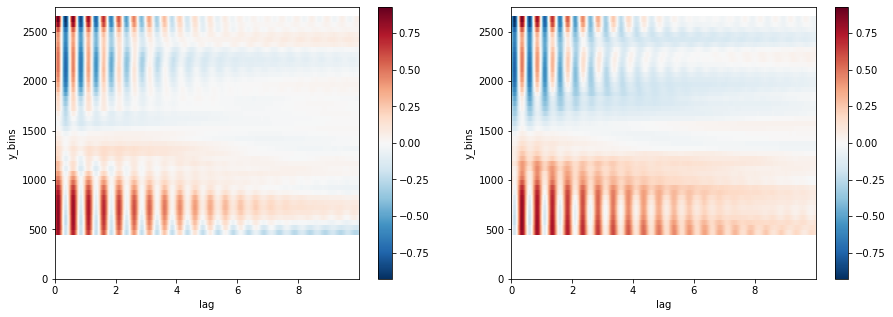

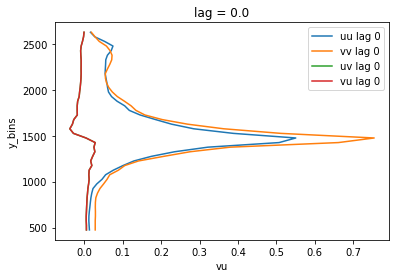

In [48]:
#Normalized autocorrelation
fig,axs=plt.subplots(1,2,figsize=(15,5))
for V,ax in zip(['uu','vv'],axs):
    (ds[V]/ds[V].sel(lag=0.)).plot(ax=ax)
fig,axs=plt.subplots(1,2,figsize=(15,5))
for V,ax in zip(['uv','vu'],axs):
    (ds[V]/np.sqrt(ds['uu'].sel(lag=0.)*ds['vv'].sel(lag=0.))).plot(ax=ax)

plt.figure()
for V in ['uu','vv','uv','vu']:
    ds[V].sel(lag=0).plot(y='y_bins',label='%s lag 0'%V)
plt.legend()

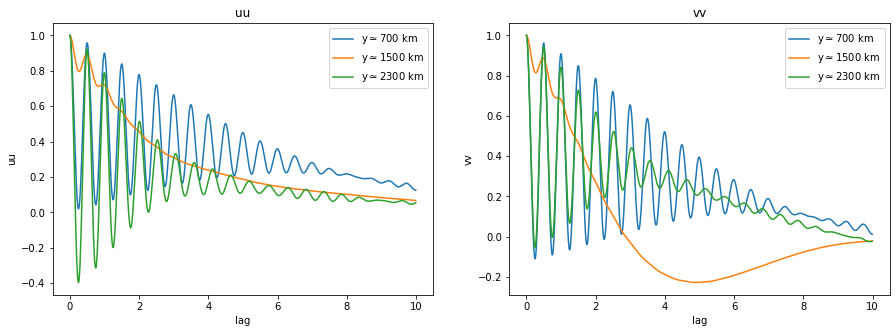

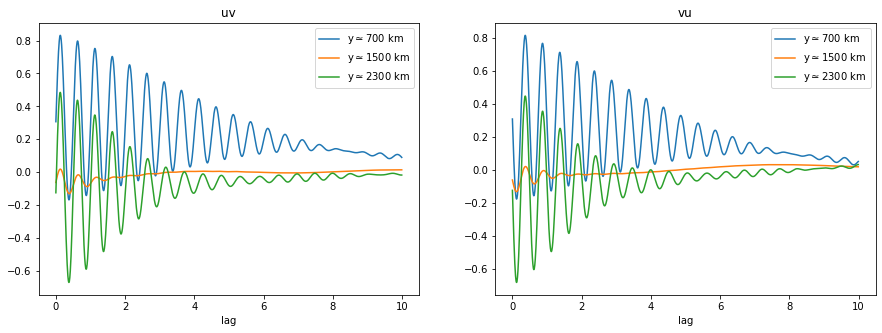

In [58]:
Y = [700,1500,2300]
fig,axs=plt.subplots(1,2,figsize=(15,5))
for y in Y:
    for V,ax in zip(['uu','vv'],axs):
        (ds[V]/ds[V].sel(lag=0.)).sel(y_bins=y,method='nearest').plot(ax=ax,label=r'y$\simeq$%s km'%y)
        ax.legend();ax.set_title(V)
fig,axs=plt.subplots(1,2,figsize=(15,5))
for y in Y:
    for V,ax in zip(['uv','vu'],axs):
        (ds[V]/np.sqrt(ds['uu'].sel(lag=0.)*ds['vv'].sel(lag=0.))).sel(y_bins=y,method='nearest').plot(ax=ax,label=r'y$\simeq$%s km'%y
                                                                                                      )
        ax.legend();ax.set_title(V)

In [59]:
attrs = {'Window' : T, 'Overlap' : 0.5, 'Bins_size' : binsize, 'Fourier window' : 'hann', 'removed':'avg_1d'}

In [64]:
ds.attrs=attrs

In [65]:
ds

<xarray.Dataset>
Dimensions:  (lag: 1440, y_bins: 55)
Coordinates:
  * y_bins   (y_bins) float64 25.0 75.0 125.0 ... 2.625e+03 2.675e+03 2.725e+03
  * lag      (lag) float64 0.0 0.006944 0.01389 0.02083 ... 9.979 9.986 9.993
Data variables:
    uu       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    vv       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    uv       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
    vu       (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Window:          20
    Overlap:         0.5
    Bins_size:       50
    Fourier window:  hann
    removed:         avg_1d

In [62]:
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)

In [67]:
r.store_diagnostic('drifters_corr20_ZC', ds, overwrite=False,file_format='netcdf')

data stored in /home/datawork-lops-osi/equinox/jetn/old/jet_cfg1_wp75_4km_1500a2000j_itide/diagnostics/drifters_corr20_ZC.nc


In [70]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
